<a href="https://colab.research.google.com/github/anurag25/shared_notebooks/blob/master/Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/kaggle_data/twitter_sa/"

input  model  output  tweet-sentiment-extraction.zip


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai.callbacks import *
from fastai.utils import *
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.cuda.set_device(0)
print(torch.cuda.get_device_name(device))

Tesla K80


In [5]:
show_install(show_nvidia_smi = True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Sat May 23 13:21:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+-----

In [6]:
path_proj = Path("/content/drive/My Drive/kaggle_data/twitter_sa")
path_data = Path("/content/drive/My Drive/kaggle_data/twitter_sa/input")
path_out = Path("/content/drive/My Drive/kaggle_data/twitter_sa/output")
path_mod = Path("/content/drive/My Drive/kaggle_data/twitter_sa/model")
path_data.ls()

[PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/input/train.csv'),
 PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/input/sample_submission.csv'),
 PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/input/test.csv')]

In [7]:
temp_df = pd.read_csv(path_data/"train.csv")
temp_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
train_df = pd.DataFrame([temp_df.sentiment, temp_df.text]).T
train_df.columns = ['label', 'text']
train_df.head()

,label,text
0,neutral,"I`d have responded, if I were going"
1,negative,Sooo SAD I will miss you here in San Diego!!!
2,negative,my boss is bullying me...
3,negative,what interview! leave me alone
4,negative,"Sons of ****, why couldn`t they put them on t..."


In [9]:
print(len(train_df))
train_df.label.value_counts()

27481


neutral     11118
positive     8582
negative     7781
Name: label, dtype: int64

In [10]:
temp_df = pd.read_csv(path_data/"test.csv")
temp_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [11]:
test_df = pd.DataFrame([temp_df.sentiment, temp_df.text]).T
test_df.columns = ['label', 'text']
test_df.head()

,label,text
0,neutral,Last session of the day http://twitpic.com/67ezh
1,positive,Shanghai is also really exciting (precisely -...
2,negative,"Recession hit Veronique Branquinho, she has to..."
3,positive,happy bday!
4,positive,http://twitpic.com/4w75p - I like it!!


In [12]:
print(len(test_df))
test_df.label.value_counts()

3534


neutral     1430
positive    1103
negative    1001
Name: label, dtype: int64

In [13]:
all_df = pd.concat([train_df, test_df])
print(len(all_df) == (len(train_df) + len(test_df)))
print(len(all_df))
all_df.label.value_counts()

True
31015


neutral     12548
positive     9685
negative     8782
Name: label, dtype: int64

In [14]:
len(train_df), len(train_df.dropna())

(27481, 27480)

In [15]:
len(test_df), len(test_df.dropna())

(3534, 3534)

In [16]:
len(all_df), len(all_df.dropna())

(31015, 31014)

In [17]:
train_df = train_df.dropna()
len(train_df)

27480

In [18]:
all_df = all_df.dropna()
len(all_df)

31014

In [0]:
train_df.to_csv(path_out/"sent_train.csv", index = False)
test_df.to_csv(path_out/"sent_test.csv", index = False)
all_df.to_csv(path_out/"sent_all.csv", index = False)

In [0]:
bs = 48

In [22]:
%%time
np.random.seed(42)
data_lm = (TextList.from_csv(path_out, "sent_all.csv", cols = 1)
            .split_by_rand_pct(0.1)
            .label_for_lm()
            .databunch(bs = bs))

data_lm.save(path_out/'data_lm.pkl')

CPU times: user 1.22 s, sys: 149 ms, total: 1.37 s
Wall time: 9.77 s


In [23]:
path_out.ls()

[PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/output/demo_data_save.pkl'),
 PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/output/models'),
 PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/output/sent_train.csv'),
 PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/output/sent_test.csv'),
 PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/output/sent_all.csv'),
 PosixPath('/content/drive/My Drive/kaggle_data/twitter_sa/output/data_lm.pkl')]

In [0]:
#data_lm = load_data(path_out, 'data_lm.pkl', bs = bs)

In [25]:
data_lm.show_batch()

idx,text
0,"some xxunk plugging for the best xxmaj rangers forum on earth xxbos s xxrep 4 o high xxbos xxmaj both of you xxbos xxmaj journey ! ? xxmaj wow ... u just became cooler . hehe ... ( is that possible ! ? ) xxbos as much as i love to be hopeful , i reckon the chances are xxunk = p i`m never gon na get my cake and"
1,", ahaha xxbos xxmaj wide awake and xxunk as xxrep 4 * . xxbos just when i thought things couldn`t get any worse . it just did . and it will get even worse tonight , i bet . my life is a misery . xxbos i don`t have the app that does it xxbos lol hi xxunk , latin would help me study for the xxunk tests to get"
2,"what a beautiful morning ! nice to be out xxbos xxup fail xxrep 9 l whenever ur xxunk then ? xxbos _ ray xxmaj bright xxmaj eyes = xxmaj xxunk xxbos http : / / xxunk / 2008 / xxunk / xxunk my hero xxbos i don`t think xxmaj i`ve ever been up this early on a xxmaj sunday in a while . xxmaj xxunk , the # xxunk awaits"
3,xxbos is getting her hair did shortly ! and hoping everything is going well for her friend currently getting surgery ! xxbos feel better ! xxunk been xxunk all week & its been rough ... xxbos xxmaj working technology ! i love you xxup waz ! xxbos xxmaj i`m so down again . i wish i could share my problems with someone ... xxbos likes xxunk dress xxbos urban think
4,1st time it`s xxunk / xxunk :] xxbos xxmaj workin ur crazy xxunk . has to be tiring .. its got ta be hard being famous but jus kno u have xxmaj xxunk of fans xxunk u xxbos xxmaj xxunk xxunk for xxmaj bill xxmaj bailey xxbos i don`t know what to do ... time is going by so fast . xxbos xxmaj this is true ... xxmaj clean clothes


In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, model_dir = path_mod, drop_mult=0.3, callback_fns=PeakMemMetric).to_fp16()

In [27]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.63E-02


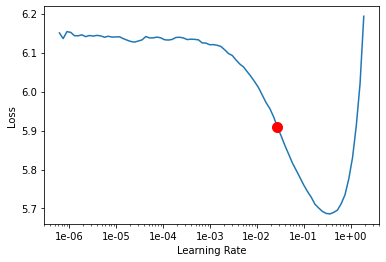

In [28]:
learn.recorder.plot(suggestion = True, skip_end=8)

In [29]:
learn.fit_one_cycle(2, 2.75E-02, moms=(0.8, 0.7), 
       callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_fit_head')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,4.622293,4.357238,0.221866,0,0,48,508,01:13
1,4.200203,4.237791,0.233211,0,0,22,490,01:13


Better model found at epoch 0 with valid_loss value: 4.357238292694092.
Better model found at epoch 1 with valid_loss value: 4.237791061401367.


In [0]:
#learn.save(path_mod/'fit_head')

In [0]:
learn.load(path_mod/'best_fit_head')

In [0]:
learn.unfreeze()

In [32]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 4.37E-04


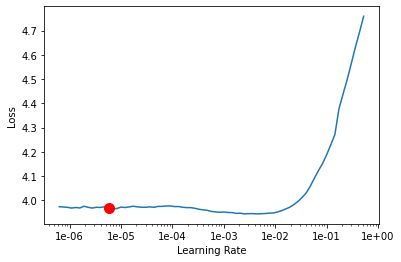

In [33]:
learn.recorder.plot(suggestion = True, skip_end = 15)

In [34]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7),
        callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_fine_tuned')])

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,3.911484,4.178699,0.239776,0,0,142,566,01:30
1,3.821932,4.136853,0.246061,0,0,0,498,01:30
2,3.583374,4.168262,0.246744,0,0,0,498,01:30
3,3.307400,4.236104,0.244590,0,0,0,498,01:30
4,3.093885,4.295594,0.242805,0,0,0,498,01:30


Better model found at epoch 0 with valid_loss value: 4.178698539733887.
Better model found at epoch 1 with valid_loss value: 4.136853218078613.


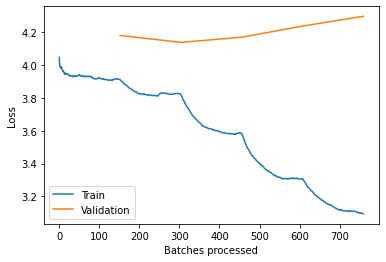

In [35]:
learn.recorder.plot_losses()

In [0]:
#learn.save(path_mod/'fine_tuned1')

In [0]:
learn.load(path_mod/'best_fine_tuned')

In [0]:
TEXT = "as much as i love to be hopeful"
N_WORDS = 20
N_SENTENCES = 1

In [38]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

as much as i love to be hopeful but i have a whole new album in my head . xxbos Well i have a slightly cold winter


In [0]:
learn.save_encoder(path_mod/"best_fine_tuned_enc")

In [42]:
%%time
bs = 128
data_clas_train =  (TextList.from_df(train_df, vocab = data_lm.vocab, cols = 1)
                    .split_by_rand_pct(0.2)
                    .label_from_df(cols = 0)
                    .databunch(bs = bs))
data_clas_train.save(path_out/'data_clas_train.pkl')

CPU times: user 1.57 s, sys: 227 ms, total: 1.8 s
Wall time: 8.72 s


In [0]:
data_clas_train = load_data(path_out, 'data_clas_train.pkl', bs = bs)

In [44]:
data_clas_train.show_batch()

text,target
"xxbos i xxup tried xxup to xxup put a xxup iron xxup on , xxup on xxup my xxup book xxup bag xxup and i xxup burnt xxup my xxup bag xxup with xxup the xxup iron xxup lol .. xxup buzz xxup keep xxup making xxup fun xxup of xxup me ... ( xxrep 4 * ) xxup lol",positive
"xxbos xxup xxunk xxup rocked xxup nashville xxup tonite .. xxup one xxup thing xxup sucked , xxup no xxup xxunk ! xxup like xxup in xxup the xxup 80`s xxup they xxup still xxup have a xxup fun xxup show . xxup xxunk xxup has xxup that xxup hott xxup bad xxup boy xxup look",neutral
xxbos xxmaj need xxmaj to xxmaj go xxmaj shopping xxmaj boring xxmaj day xxmaj xxunk xxrep 4 . xxmaj nothing xxmaj to xxmaj dooo . xxmaj college xxmaj xxunk ... xxmaj how xxrep 4 * ` xxmaj xxunk ` xxmaj wish xxmaj twitter xxmaj was xxmaj xxunk xxmaj for xxmaj me = ] <3,negative
"xxbos xxmaj music xxmaj update xxmaj before xxmaj leaving . xxmaj check out the songs xxmaj xxunk by xxmaj air , xxmaj disco xxmaj friends by xxmaj just xxmaj jack , xxmaj stand xxmaj up by xxmaj the xxmaj xxunk . xxmaj and xxmaj enjoy ! ! !",positive
"xxbos xxup xxunk xxup xxunk xxup slow xxup dance xxup rockin ` xxup the xxrep 4 * xxup out xxup of xxup my xxup playlist xxup right xxup now ! xxup get xxup up xxup on xxup this xxup song , xxup pure xxrep 4 * xxup xxunk",positive


In [0]:
learn = text_classifier_learner(data_clas_train, AWD_LSTM, drop_mult = 0.5, callback_fns=PeakMemMetric).to_fp16()
learn.load_encoder(path_mod/"best_fine_tuned_enc")

In [47]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.63E-02


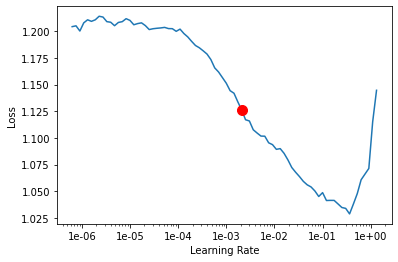

In [48]:
learn.recorder.plot(suggestion = True)

In [49]:
learn.fit_one_cycle(1, 2.09E-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.919775,0.813480,0.634825,10,11,2,296,00:26


In [0]:
learn.save(path_mod/"clas_first")

In [0]:
learn.load(path_mod/"clas_first")

In [0]:
learn.freeze_to(-2)

In [53]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.45E-04


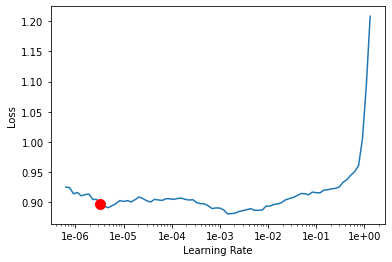

In [54]:
learn.recorder.plot(suggestion = True)

In [58]:
learn.fit_one_cycle(1, slice(1E-02/(2.6**4), 1E-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.795358,0.703712,0.695961,12,12,2,178,00:28


In [0]:
learn.save(path_mod/"clas_second")

In [0]:
learn.load(path_mod/"clas_second")

In [0]:
learn.freeze_to(-3)

In [63]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.10E-07


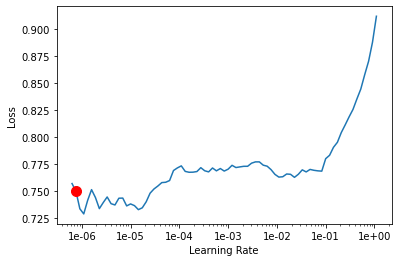

In [65]:
learn.recorder.plot(suggestion = True)

In [66]:
learn.fit_one_cycle(1, slice(5E-03/(2.6**4),5E-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.722318,0.625968,0.737627,0,1,-2,288,00:46


In [0]:
learn.save(path_mod/"clas_third")

In [0]:
learn.load(path_mod/"clas_second")

In [69]:
learn.fit_one_cycle(1, slice(1E-02/(2.6**4),1E-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.702306,0.613064,0.749272,0,1,66,398,00:46


In [0]:
learn.save(path_mod/"clas_third")

In [0]:
learn.load(path_mod/"clas_second")

In [73]:
learn.fit_one_cycle(1, slice(5E-02/(2.6**4),5E-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.680837,0.593767,0.762373,10,11,142,294,00:45


In [0]:
learn.save(path_mod/"clas_third")

In [0]:
learn.unfreeze()

In [78]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-05
Min loss divided by 10: 1.58E-05


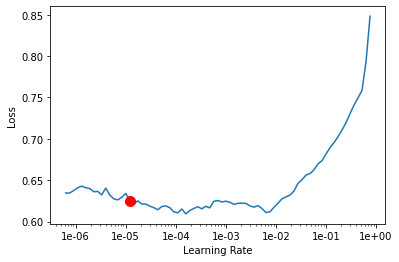

In [80]:
learn.recorder.plot(suggestion = True)

In [81]:
learn.fit_one_cycle(2, slice(5E-03/(2.6**4),5E-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.595738,0.582857,0.766012,0,1,204,516,01:04
1,0.542246,0.575124,0.767103,0,1,-2,484,01:05


In [0]:
learn.save(path_mod/"clas_unfreeze")

In [0]:
learn.load(path_mod/"clas_third")

In [84]:
learn.fit_one_cycle(2, slice(1E-02/(2.6**4),1E-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.602955,0.587271,0.758552,10,11,224,464,01:01
1,0.513589,0.572102,0.778748,2,2,2,432,01:05


In [0]:
learn.save(path_mod/"clas_unfreeze")

In [93]:
learn.fit_one_cycle(2, slice(1E-02/(2.6**4),1E-02), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.514907,0.598180,0.756186,0,1,256,554,00:59
1,0.402035,0.619691,0.768741,2,2,-2,486,01:01


In [0]:
learn.load(path_mod/"clas_unfreeze")

In [95]:
learn.predict("I really loved that movie, it was awesome!")

(Category tensor(2), tensor(2), tensor([8.8102e-05, 9.8396e-04, 9.9893e-01]))

In [96]:
data_clas_train.classes

['negative', 'neutral', 'positive']

In [97]:
data_clas_train

TextClasDataBunch;

Train: LabelList (21984 items)
x: TextList
xxbos xxmaj i`d have xxunk , if i were going,xxbos my boss is xxunk me ...,xxbos what interview ! leave me alone,xxbos http : / / xxunk / xxunk - some xxunk plugging for the best xxmaj rangers forum on earth,xxbos s xxrep 4 o high
y: CategoryList
neutral,negative,negative,neutral,neutral
Path: .;

Valid: LabelList (5496 items)
x: TextList
xxbos i xxup am xxup such a xxup xxunk i feel disappointed because of it . xxrep 4 * my xxunk skills the internet = no more privacy .,xxbos xxmaj i`m going to see xxunk todd on stage with my best friend for her bday today ( i know xxmaj i`m going to be the one who sings along ! ! ),xxbos anyone excited for harry potter like i am . xxrep 4 * twilight postponed my first love oh well off to find some hai chai,xxbos xxmaj mama ? you`re the best thing that ever happen to me . thanks for everything & and sorry for hurting you ... i xxup love xxup you ! <3,xxbos poor bella is in the xxup er with 